## Imports and data-reading

In [1]:
import pandas as pd
# !pip install cvxopt
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import SVC
from sklearn import datasets

## Useful Functions for any part

### For SVM/SVC plotting

In [2]:
def plot_it_all_poly(train_X, train_y, test_X, test_y, reg_pam, ker_coeff_pam):

    ######################################### 3D plot ########################################
    Z = np.ones((len(reg_pam),len(ker_coeff_pam)))
    W = np.ones((len(reg_pam),len(ker_coeff_pam)))
    X, Y = np.meshgrid(reg_pam, ker_coeff_pam)


    for idxc, c in enumerate(reg_pam):
        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
#             mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            Z[idxc][idxg] = mod.score(train_X, train_y)
            W[idxc][idxg] = mod.score(test_X, test_y)

    # print(X, Y, Z, W, X.shape, Y.shape, Z.shape, W.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(np.log10(X), np.log10(Y), Z, rstride=1, cstride=1, label='train', color='blue' )
    ax.plot_wireframe(np.log10(X), np.log10(Y), W, rstride=1, cstride=1, label='test', color='red')
    ax.set_title('Poly kernel: C and Gamma Vs Accuracy')
    ax.set_xlabel('log(C)')
    ax.set_ylabel('log(Gamma)')

    plt.legend()
    plt.show()


    ######################################## My conventional plots ########################################
    for idxc, c in enumerate(reg_pam):
        E_score_train = []
        E_score_test = []

        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
            #mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            E_score_train.append(mod.score(train_X, train_y))
            E_score_test.append(mod.score(test_X, test_y))

        plt.plot(ker_coeff_pam, E_score_test, "r-", label="Test")
        plt.plot(ker_coeff_pam, E_score_train, "b-", label="Train")
        plt.xscale('log')
        plt.xlabel(r'$\Gamma$')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Score for C=%s'%(c))
        plt.show()


        
def plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam):

    ######################################## My conventional plots ########################################
    E_score_train = []
    E_score_test = []

    for idxc, c in enumerate(reg_pam):    
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear', C = c))]
        pipeline = Pipeline(ppl) 
        mod = pipeline
#         mod = svm.SVC(kernel='poly', C = c, gamma = g)
        mod.fit(train_X, np.ravel(train_y, order='C'))
        E_score_train.append(mod.score(train_X, train_y))
        E_score_test.append(mod.score(test_X, test_y))

    plt.plot(reg_pam, E_score_test, "r-", label="Test")
    plt.plot(reg_pam, E_score_train, "b-", label="Train")
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.legend()
#     plt.title('Score for C=%s'%(c))
    plt.show()

        
        
        
######################################## PLOTS FOR GRID SEARCH ########################################

def plot_search_results(grid):
    # Reference: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey=False,figsize=(len(params)*10,len(params)*2.5))
    fig.suptitle('Score per parameter')
    fig.text(0.085, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
#         m=np.array(masks[:i])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        if (x[-1]>=x[-2]*9):
            ax[i].set_xscale('log')
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid(True)

    plt.legend()
    plt.show()


    
def plot_search_results_linear(grid, reg_pam):
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']


    # print('mean_test_score: ', means_test)
    # print('std_test_score: ', stds_test)
    # print('mean_train_score: ', means_train)
    # print('std_train_score: ', stds_train)
    x = reg_pam
    y_1 = np.array(means_test)
    e_1 = np.array(stds_test)
    y_2 = np.array(means_train)
    e_2 = np.array(stds_train)
    plt.errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    plt.errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    plt.grid(True)
    plt.xscale('log')
    plt.title('Score Vs C')
    plt.legend(loc='lower right')
    plt.ylabel('Score')
    plt.xlabel('C')
    plt.show()

### For CVXOPT

In [49]:
# Reference: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
# Reference: https://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf

def cvx_try(X, y, X_test, y_test, which, C=1.0, gamma=0.04, coef0= 0.0, degree=3, threshold=1e-4):
    
    y_temp = y.reshape(-1, 1)*1.
#     X_temp = y_temp*X
#     H = np.dot(X_temp, X_temp.T)*1.
    def makeHP(X1, X2, y_temp, which):
        H = np.dot(X1, X2.T)
        if (which=='linear'):
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='poly'):
            H = (gamma*H+coef0)**degree
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='sigmoid'):
            H = np.tanh(gamma*H+coef0)
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='rbf'):
            H1 = np.diag(X1.dot(X1.T)).reshape(-1, 1)*np.ones((1, X2.shape[0]))
            H2 = np.diag(X2.dot(X2.T)).reshape(1, -1)*np.ones((X1.shape[0],1))
            H = 2*H-H1-H2
            H = np.exp(gamma*H)
            P = matrix(y_temp.dot(y_temp.T)*H)
    
        return H,P
    
    H,P = makeHP(X, X, y_temp, which)
    q = matrix(-np.ones((X.shape[0], 1)))
    A = matrix(y_temp.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(np.r_[-1*(np.eye(X.shape[0])), np.eye(X.shape[0])])
    h = matrix(np.r_[np.zeros(X.shape[0]), np.ones(X.shape[0])*C])
    print(repr(q),repr(A),repr(b),repr(G),repr(h))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    lambs, _ = np.array(sol['x']), np.array(sol['primal objective'])
    
    
    ########## GET SUPPORT VECTORS ################
    idx = np.where(lambs > threshold)[0] # Indices of support vectors
    #Extract support vectors
    sX = X[idx,:]
    sy = y[idx]
    lambs = lambs[idx]
    b = np.sum(sy)
    for j in idx:
        b = b - np.sum(lambs*sy*(H[j, idx].reshape(-1, 1)))
    b /= idx.shape[0]
    
    
    
    ######### PREDICT ###########
    ynew = np.zeros((X_test.shape[0],))
    Htemp,_ = makeHP(sX, test_X, ynew, which)
    rightcnt = 0.
#     print(ynew.shape, Htemp.shape)
    for i in range(ynew.shape[0]):
        ynew[i] = np.sum(lambs*sy*Htemp[:,i].reshape(-1,1))+b
        if (ynew[i]*y_test[i]>0):
            rightcnt+=1.
    y_pred = np.sign(ynew)
    score = rightcnt*100.0/ynew.shape[0]
    
    
    
    return lambs, sX, sy, y_pred, score

## Part 1A

### Data Import + Initialize

In [ ]:
lab1 = 0
lab2 = 1
num_ft = 10
split_frac = 0.8
random_state = 69420
file_name = '2019EE10143.csv'


# Import
df = pd.read_csv(file_name, header=None)

#Convert to use
df_temp = df.loc[df[25].isin([lab1, lab2])]
print(len(df_temp))
df_temp.iloc[df_temp[25] == lab1, 25] = -1
df_temp.iloc[df_temp[25] == lab2, 25] = 1
df_temp = df_temp.sample(frac=1.)

train_df = df_temp[:int(split_frac*len(df_temp))]
test_df = df_temp[int(split_frac*len(df_temp)):]

X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
y_train_temp = train_df.loc[:, [25]]
X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
y_test_temp = test_df.loc[:, [25]]

# print(X_train_temp.head())
# print(y_train_temp.head())
# print(X_test_temp.head())
# print(y_test_temp.head())

print(len(X_train_temp), len(y_train_temp), len(X_test_temp), len(y_test_temp))


train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)
test_X = np.array(X_test_temp.values)
test_y = np.array(y_test_temp.values)

print (train_X.shape)
print (train_y.shape)
print (test_X.shape)
print (test_y.shape)

### Grid Search SVM

In [47]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

low_reg, high_reg = -5,5
low_cof, high_cof = -3,3
low_deg, high_deg = 1, 6

reg_pam = np.logspace(low_reg, high_reg, num=1+high_reg-low_reg)
ker_coeff_pam = np.logspace(low_cof, high_cof, num=1+high_cof-low_cof)
deg_pam = np.linspace(low_deg, high_deg, 1+low_deg+high_deg)


ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly'))]
pipeline = Pipeline(ppl) 
# parameters = {'SVM__C':reg_pam} #Linear
parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly
# parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, return_train_score=True)

grid.fit(train_X, np.ravel(train_y, order='C'))
print(grid.score(train_X, train_y))
print(grid.score(test_X, test_y))
bestpar = grid.best_params_
print(bestpar)

mod = svm.SVC(kernel='poly', C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma'], degree= bestpar['SVM__degree'])
mod.fit(train_X, np.ravel(train_y, order='C'))
print(mod.score(train_X, train_y))
print(mod.score(test_X, test_y))
print(sorted(mod.support_vectors_, key=lambda x: x[0]))

0.9979338842975206
1.0
{'SVM__C': 0.01, 'SVM__degree': 1.0, 'SVM__gamma': 1000.0}
1.0
0.9917355371900827
[array([-1.94047783, -0.59404481,  1.62592456,  1.31214335,  0.55917462,
        2.77954685, -2.94160016,  0.09023557, -0.36688979,  0.34897057]), array([-1.69790865, -0.14900708, -1.45748286,  0.16046577,  0.4779497 ,
       -2.35441859,  1.24388444, -1.09576342, -0.22069924,  1.37331691]), array([-1.62410951,  0.17525191,  0.78955537, -1.67133864,  0.97864023,
       -0.49141539,  1.16826925,  0.60176822, -0.38505255,  0.74013041]), array([-1.55273591, -0.68410391, -0.76341679, -1.3259031 , -1.68824719,
       -2.28984977,  1.29874316, -1.63046122, -0.63093164,  0.00850813]), array([-1.54261417,  0.30739635, -1.59332713,  1.46957368,  0.03795295,
       -1.31261301, -0.59115292, -0.43047483, -0.49556236,  0.14898264]), array([-1.36257971, -1.96644095,  0.73256698,  0.64308138, -1.26743175,
       -1.04431212, -2.08032059,  1.15287226,  2.57996889,  0.94873595]), array([-1.07836527

### Plottings

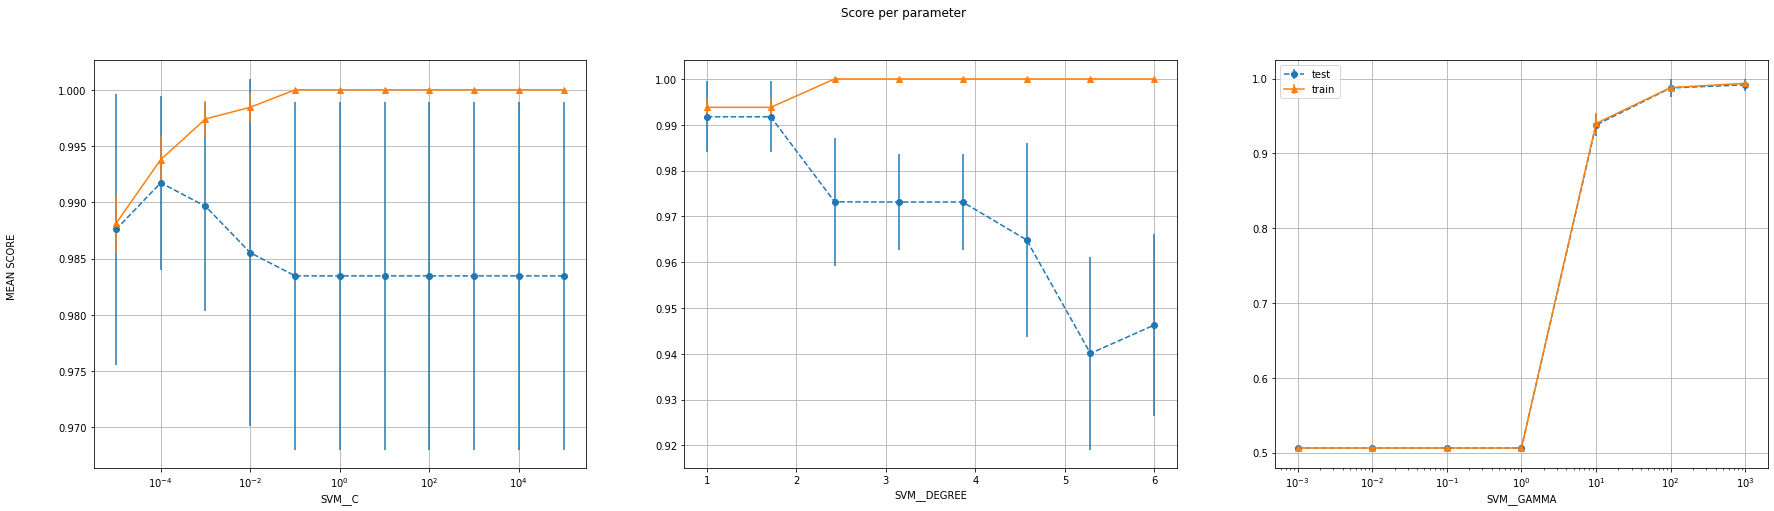

In [18]:
# plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam)
# plot_search_results_linear(grid, reg_pam)
plot_search_results(grid)

In [ ]:
# pipeline = svm.SVC(kernel='linear', C=0.01)
# pipeline.fit(train_X, np.ravel(train_y, order='C'))
# print('w = ',pipeline.coef_)
# print('b = ',pipeline.intercept_)
# # print('Indices of support vectors = ', pipeline.support_)
# print('Support vectors = ', pipeline.support_vectors_)
# # print('Number of support vectors for each class = ', pipeline.n_support_)
# # print('Coefficients of the support vector in the decision function = ', np.abs(pipeline.dual_coef_))

## CVXOPT

In [48]:
# cvx_try(X, y, X_test, y_test, which, C=1.0, gamma=0.04, coef0= 0.0, degree=3, threshold=1e-4):
legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='poly', C=0.01, gamma=1000, degree=1)

<484x1 matrix, tc='d'> <1x484 matrix, tc='d'> <1x1 matrix, tc='d'> <968x484 matrix, tc='d'> <968x1 matrix, tc='d'>
(121,) (9, 121)


In [51]:
# threshold = 1e-4
# ############ https://xavierbourretsicotte.github.io/SVM_implementation.html #########
# #w parameter in vectorized form
# w = ((train_y * idk).T @ train_X).reshape(-1,1)
# #Selecting the set of indices S corresponding to non zero parameters
# S = (idk > threshold).flatten()
# #Computing b
# b = train_y[S] - np.dot(train_X[S], w)
# #Display results
# # print('Alphas = ',idk[idk > threshold])
# print('w = ', w.flatten())
# print('b = ', b[0])

# suppV = (suppX, suppy)
# print("Support vectors: ", suppV)
print("Support vectors: ", sorted(suppX, key=lambda x: x[0]))
print("CVX score: ", acc)

Support vectors:  [array([-1.94047783, -0.59404481,  1.62592456,  1.31214335,  0.55917462,
        2.77954685, -2.94160016,  0.09023557, -0.36688979,  0.34897057]), array([-1.69790865, -0.14900708, -1.45748286,  0.16046577,  0.4779497 ,
       -2.35441859,  1.24388444, -1.09576342, -0.22069924,  1.37331691]), array([-1.62410951,  0.17525191,  0.78955537, -1.67133864,  0.97864023,
       -0.49141539,  1.16826925,  0.60176822, -0.38505255,  0.74013041]), array([-1.55273591, -0.68410391, -0.76341679, -1.3259031 , -1.68824719,
       -2.28984977,  1.29874316, -1.63046122, -0.63093164,  0.00850813]), array([-1.54261417,  0.30739635, -1.59332713,  1.46957368,  0.03795295,
       -1.31261301, -0.59115292, -0.43047483, -0.49556236,  0.14898264]), array([-1.36257971, -1.96644095,  0.73256698,  0.64308138, -1.26743175,
       -1.04431212, -2.08032059,  1.15287226,  2.57996889,  0.94873595]), array([-1.07836527,  0.48191267,  0.38393846,  2.38360899, -3.2936363 ,
       -0.33769804, -0.84311013, 

In [54]:
print('heck yeah')

heck yeah
